In [177]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1145]:
from nb_001b import *
from PIL import Image
import sys, PIL, matplotlib.pyplot as plt
from torch.utils.data import Dataset
from operator import itemgetter, attrgetter
from numpy import random, cos, sin, tan, tanh

# CIFAR subset data

## Setup

In [179]:
DATA_PATH = Path('data')
PATH = DATA_PATH/'cifar10_dog_air'
TRAIN_PATH = PATH/'train'

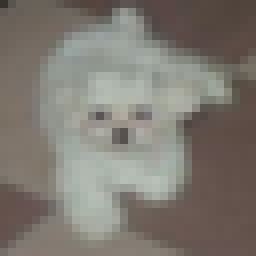

In [180]:
dog_fn = list((TRAIN_PATH/'dog').iterdir())[0]
dog_image = Image.open(dog_fn)
dog_image.resize((256,256))

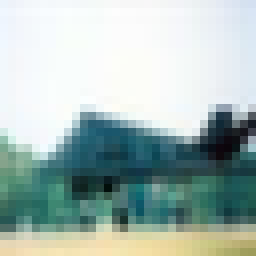

In [181]:
air_fn = list((TRAIN_PATH/'airplane').iterdir())[0]
air_image = Image.open(air_fn)
air_image.resize((256,256))

## Simple Dataset/Dataloader

In [195]:
def find_classes(folder):
    classes = [d for d in folder.iterdir()
               if d.is_dir() and not d.name.startswith('.')]
    assert(len(classes)>0)
    return sorted(classes, key=lambda d: d.name)

def get_image_files(c):
    return [o for o in list(c.iterdir())
            if not o.name.startswith('.') and not o.is_dir()]

def pil2tensor(image):
    arr = np.array(image, dtype=np.float32)/255.
    if len(arr.shape)==2: arr = np.repeat(arr[...,None],3,2)
    return torch.from_numpy(arr).permute(2,0,1).contiguous()

In [196]:
class FilesDataset(Dataset):
    def __init__(self, folder, classes):
        self.fns, self.y = [], []
        self.classes = classes
        for i, cls in enumerate(classes):
            fnames = get_image_files(folder/cls)
            self.fns += fnames
            self.y += [i] * len(fnames)
        
    def __len__(self): return len(self.fns)

    def __getitem__(self,i):
        x = PIL.Image.open(self.fns[i]).convert('RGB')
        return pil2tensor(x),self.y[i]

In [197]:
# NB: validation or training may not have all classes
classes = [cls.name for cls in find_classes(PATH/'train')]

train_ds = FilesDataset(PATH/'train', classes)
valid_ds = FilesDataset(PATH/'test', classes)

In [198]:
len(train_ds), len(valid_ds)

(10000, 2000)

In [200]:
def image2np(image): return image.cpu().permute(1,2,0).numpy()

airplane


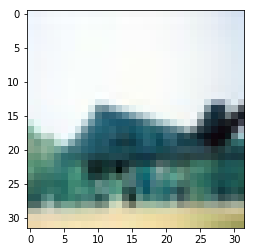

In [201]:
x,y = train_ds[0]
plt.imshow(image2np(x))
print(train_ds.classes[y])

In [202]:
import torch
default_device = torch.device('cuda', 0)

In [203]:
bs=64

In [204]:
data = DataBunch(train_ds, valid_ds, bs=bs)
len(data.train_dl), len(data.valid_dl)

(157, 16)

In [208]:
def show_image(img, ax=None, figsize=(3,3)):
    if ax is None: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(image2np(img))
    ax.axis('off')

def show_image_batch(dl, classes, rows=None):
    if rows is None: rows = int(math.sqrt(len(x)))
    x,y = next(iter(dl))[:rows*rows]
    show_images(x,y,rows, classes)

def show_images(x,y,rows, classes):
    fig, axs = plt.subplots(rows,rows,figsize=(12,15))
    for i, ax in enumerate(axs.flatten()):
        show_image(x[i], ax)
        ax.set_title(classes[y[i]])
    plt.tight_layout()

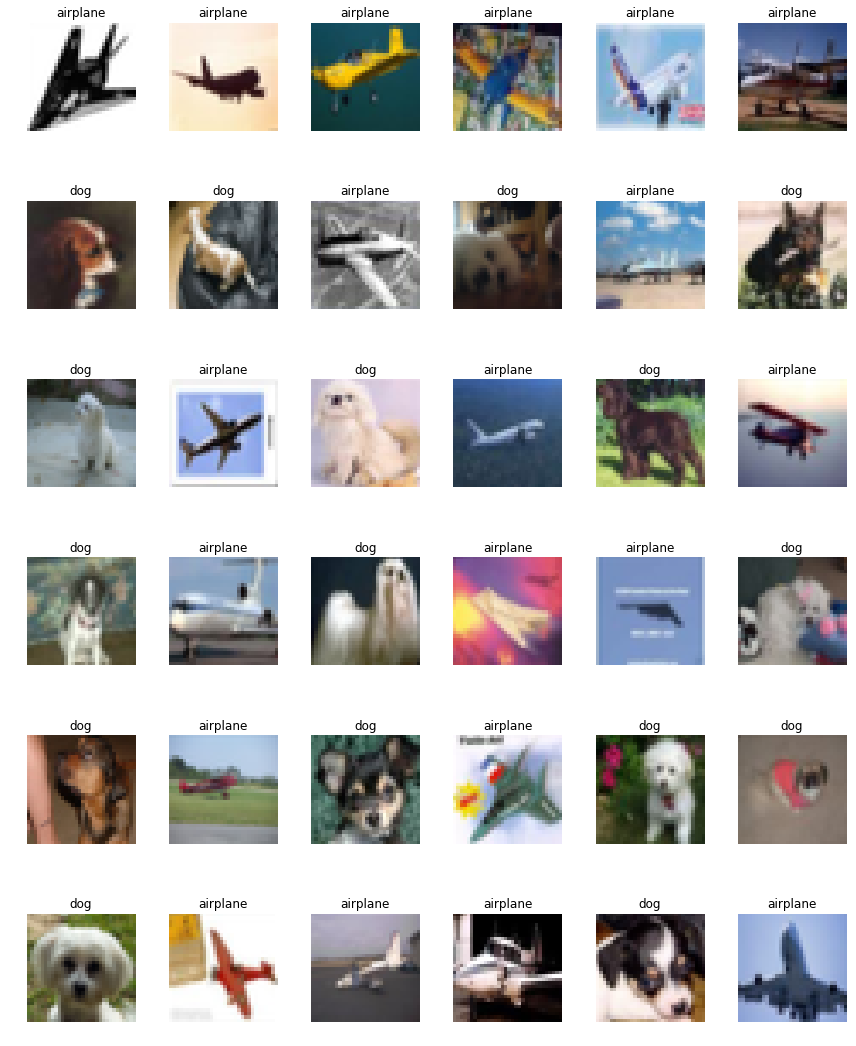

In [209]:
show_image_batch(data.train_dl, classes, 6)

## Simplify transforms

In [211]:
x,_ = next(iter(data.train_dl))

In [212]:
x.shape

torch.Size([64, 3, 32, 32])

In [252]:
def get_batch_stats(dl):
    x,_ = next(iter(dl))
    # hack for multi-axis reduction until pytorch has it natively
    x = x.transpose(0,1).contiguous().view(x.size(1),-1)
    return x.mean(1), x.std(1)

In [253]:
data_mean,data_std = get_batch_stats(data.train_dl)
data_mean,data_std

(tensor([0.5017, 0.5105, 0.5048], device='cuda:0'),
 tensor([0.2404, 0.2411, 0.2642], device='cuda:0'))

In [254]:
noop = lambda x: x

def xy_transform(x_tfm=None, y_tfm=None):
    if x_tfm is None: x_tfm = noop
    if y_tfm is None: y_tfm = noop
    return lambda b: (x_tfm(b[0]), y_tfm(b[1]))

def xy_transforms(x_tfms=None, y_tfms=None):
    x_tfms = listify(x_tfms)
    if y_tfms is None: y_tfms=noop
    y_tfms = listify(y_tfms, x_tfms)
    return list(map(xy_transform, x_tfms, y_tfms))

In [255]:
def normalize(mean,std,x): return (x-mean.reshape(3,1,1))/std.reshape(3,1,1)

In [256]:
cifar_transforms = [
    partial(normalize, data_mean, data_std)
]

cifar_xy_transforms = xy_transforms(cifar_transforms)

In [257]:
data2 = DataBunch(train_ds, valid_ds, bs=bs, train_tfms=cifar_xy_transforms, valid_tfms=cifar_xy_transforms)
len(data2.train_dl), len(data2.valid_dl)

(157, 16)

In [265]:
x,y = next(iter(data2.train_dl))

In [266]:
def denorm(x): return x * data_std.reshape(3,1,1) + data_mean.reshape(3,1,1)

In [267]:
x = denorm(x)

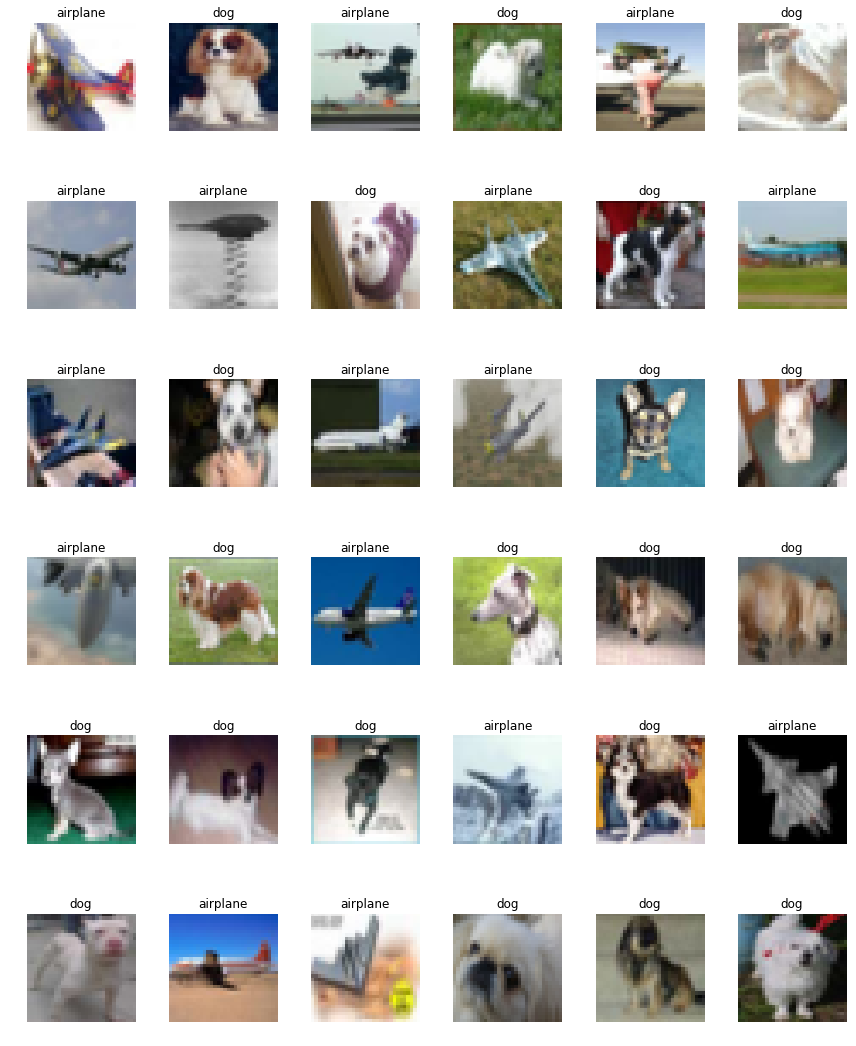

In [268]:
show_images(x,y,6,classes)

In [269]:
learn = Learner(data2, simple_cnn([3,16,16,2], [3,3,3], [2,2,2]))

In [270]:
learn.fit(2, 0.1)

0 0.5448387775421143


1 0.44640082454681396


# Data augmentation

## Lighting

In [1169]:
from enum import Enum
import scipy.special

TfmTypes = Enum('Tfm', 'Pixel Coord Affine')

In [1170]:
def log_uniform(low, high): return np.exp(random.uniform(np.log(low), np.log(high)))

In [1171]:
scipy.stats.gmean([log_uniform(0.5,2.0) for _ in range(1000)])

1.0182568677075672

In [ ]:
def logit(x): return (x/(1-x)).log()
def logit_(x): return (x.div_(1-x)).log_()

In [1172]:
def brightness(x, change: random.uniform) -> TfmTypes.Pixel:
    return x.add_(scipy.special.logit(change))

def contrast(x, scale: log_uniform) -> TfmTypes.Pixel:
    return x.mul_(scale)

In [1173]:
def apply_pixel_tfm(func):
    return lambda x: func(logit_(x)).sigmoid()

In [1174]:
def apply_contrast(scale):
    return apply_pixel_tfm(partial(contrast, scale=scale))

In [1175]:
x = lambda: train_ds[1][0]

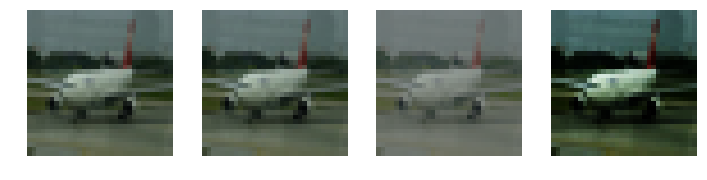

In [1179]:
_,axes = plt.subplots(1,4, figsize=(12,3))

show_image(x(), axes[0])
show_image(apply_contrast(1.0)(x()), axes[1])
show_image(apply_contrast(0.5)(x()), axes[2])
show_image(apply_contrast(2.0)(x()), axes[3])

In [1180]:
def apply_brightness(change):
    return apply_pixel_tfm(partial(brightness, change=change))

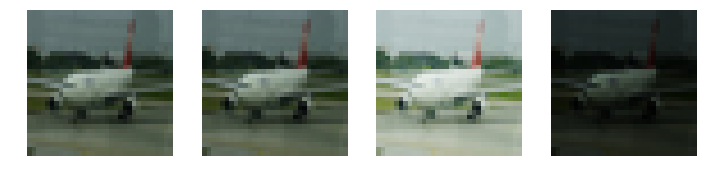

In [1181]:
_,axes = plt.subplots(1,4, figsize=(12,3))

show_image(x(), axes[0])
show_image(apply_brightness(0.5)(x()), axes[1])
show_image(apply_brightness(0.8)(x()), axes[2])
show_image(apply_brightness(0.2)(x()), axes[3])

In [1182]:
def apply_brightness_contrast(scale_contrast, change_brightness):
    return apply_pixel_tfm(compose([
        partial(contrast, scale=scale_contrast),
        partial(brightness, change=change_brightness)
    ]))

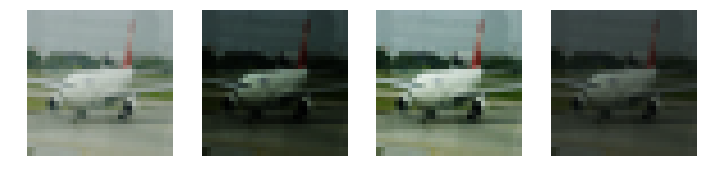

In [1183]:
_,axes = plt.subplots(1,4, figsize=(12,3))

show_image(apply_brightness_contrast(0.75, 0.7)(x()), axes[0])
show_image(apply_brightness_contrast(1.3,  0.3)(x()), axes[1])
show_image(apply_brightness_contrast(1.3,  0.7)(x()), axes[2])
show_image(apply_brightness_contrast(0.75, 0.3)(x()), axes[3])

## Random lighting

In [1184]:
def resolve_args(func, **kwargs):
    return {k:v(*kwargs[k]) for k,v in func.__annotations__.items() if k != 'return'}

In [1185]:
resolve_args(brightness, change=(0.25,0.75))

{'change': 0.371017433633684}

In [1186]:
this_module = sys.modules[__name__]

In [1187]:
def make_tfm_funcs(func):
    rfunc = lambda **kwargs: partial(func, **resolve_args(func, **kwargs))
    tfunc = lambda **kwargs: lambda x: rfunc(**kwargs)(x)
    setattr(this_module, f'{func.__name__}_rand', rfunc)
    setattr(this_module, f'{func.__name__}_tfm', tfunc)

In [1188]:
make_tfm_funcs(brightness)
make_tfm_funcs(contrast)

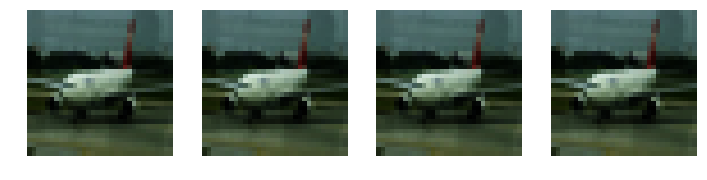

In [1189]:
tfm = apply_pixel_tfm(contrast_rand(scale=(0.5,2.0)))

# all the same
_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(tfm(x()), ax)

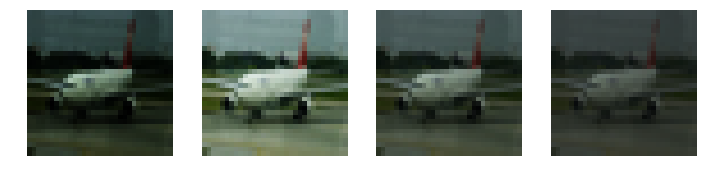

In [1190]:
tfms = [contrast_tfm(scale=(0.5,2.0)),
        brightness_tfm(change=(0.25,0.75))]
tfm = apply_pixel_tfm(compose(tfms))

# all different
_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(tfm(x()), ax)

## Decorator

In [1191]:
def reg_transform(func):
    make_tfm_funcs(func)
    return func

In [1192]:
@reg_transform
def brightness(x, change: random.uniform) -> TfmTypes.Pixel:
    return x.add_(scipy.special.logit(change))

@reg_transform
def contrast(x, scale: log_uniform) -> TfmTypes.Pixel:
    return x.mul_(scale)

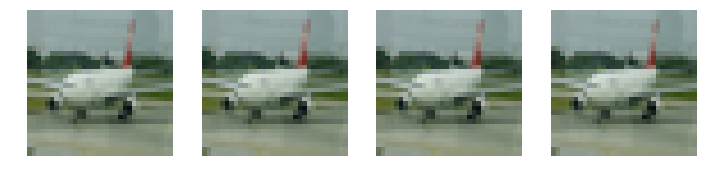

In [1193]:
_,axes = plt.subplots(1,4, figsize=(12,3))

tfm = apply_pixel_tfm(brightness_rand(change=(0.2,0.8)))
for ax in axes: show_image(tfm(x()), ax)

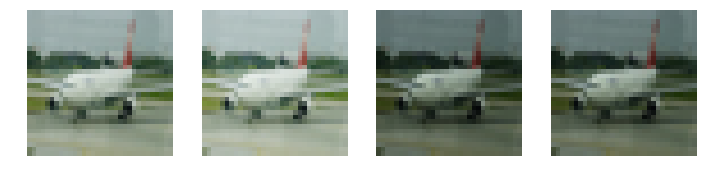

In [1194]:
_,axes = plt.subplots(1,4, figsize=(12,3))

tfm = apply_pixel_tfm(brightness_tfm(change=(0.2,0.8)))
for ax in axes: show_image(tfm(x()), ax)

# Affine

## Deterministic affine

In [1151]:
def grid_sample(x, coords, padding='reflect'):
    if padding=='reflect': # Reflect padding isn't implemented in grid_sample yet
        coords[coords < -1] = coords[coords < -1].mul_(-1).add_(-2)
        coords[coords > 1] = coords[coords > 1].mul_(-1).add_(2)
        padding='zeros'
    return F.grid_sample(x[None], coords, padding_mode=padding)[0]

def affine_grid(x, matrix): return F.affine_grid(matrix[None,:2], x[None].size())

In [1276]:
def rotate(degrees: random.uniform) -> TfmTypes.Affine:
    angle = degrees * math.pi / 180
    return [[cos(angle), -sin(angle), 0.],
            [sin(angle),  cos(angle), 0.],
            [0.        ,  0.        , 1.]]

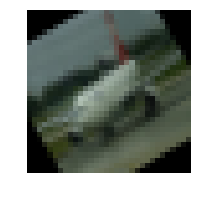

In [1277]:
img = x()
m = rotate(30)
m = img.new_tensor(m)
c = affine_grid(img, m)
img2 = grid_sample(img, c, padding='zeros')
show_image(img2)

In [1370]:
def do_affine(x, m=None, funcs=None):
    if m is None: m=eye_new(x, 3)
    c = affine_grid(img,  img.new_tensor(m))
    c = compose(funcs)(c)
    return grid_sample(img, c, padding='zeros')

In [1371]:
def zoom(scale: random.uniform) -> TfmTypes.Affine:
    return [[scale, 0,     0.],
            [0,     scale, 0.],
            [0,     0   ,  1.]]

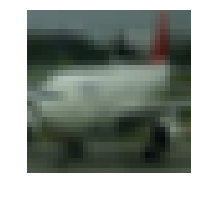

In [1372]:
show_image(do_affine(x(), zoom(0.6)))

In [1373]:
def eye_new(x, n): return torch.eye(n, out=x.new_empty((n,n)))

def affines_mat(x, matrices):
    matrices = list(map(x.new_tensor, matrices))
    return reduce(torch.matmul, matrices, eye_new(x, 3))

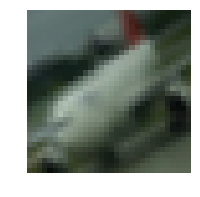

In [1374]:
img = x()
c = affines_mat(img, [zoom(0.6), rotate(30)])
show_image(do_affine(img, c))

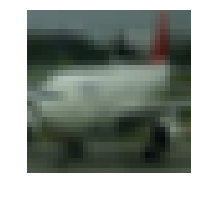

In [1375]:
img = x()
img2 = do_affine(img,  rotate(30))
img2 = do_affine(img2, zoom(0.6))
show_image(img2)

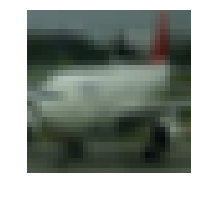

In [1376]:
img = x()
c = affines_mat(img, [zoom(0.6)])
show_image(do_affine(img, c))

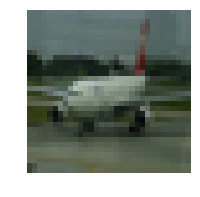

In [1377]:
img = x()
c = affines_mat(img, [])
show_image(do_affine(img, c))

## Random affine

In [1379]:
def affine_rand(func, **kwargs): return func(**resolve_args(func, **kwargs))

In [1380]:
def make_affine_funcs(func):
    rfunc = partial(affine_rand, func)
    tfunc = lambda **kwargs: lambda: rfunc(**kwargs)
    setattr(this_module, f'{func.__name__}_rand', rfunc)
    setattr(this_module, f'{func.__name__}_tfm', tfunc)

In [1381]:
def apply_affine_tfms(x, funcs):
    matrices = [f() for f in listify(funcs)]
    return do_affine(x, affines_mat(x, matrices))

In [1382]:
make_affine_funcs(rotate)
make_affine_funcs(zoom)

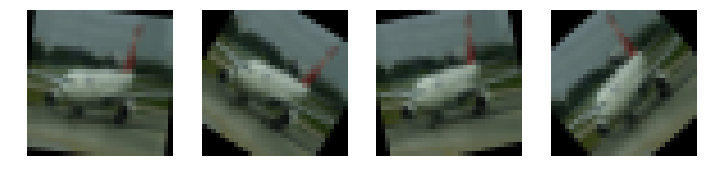

In [1383]:
tfm = rotate_tfm(degrees=(-45,45.))

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(apply_affine_tfms(x(), tfm), ax)

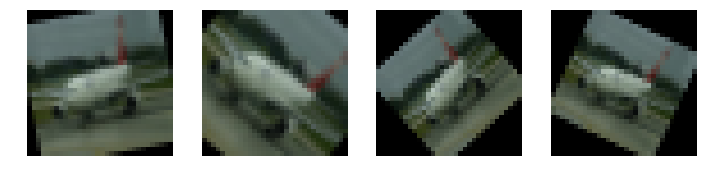

In [1384]:
tfms = [rotate_tfm(degrees=(-45,45.)),
        zoom_tfm(scale=(0.75,1.5))]

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(apply_affine_tfms(x(), tfms), ax)

## Jitter

In [1385]:
def get_coords(x):
    matrix = torch.tensor([[1., 0., 0.], [0., 1., 0.]], device=x.device)
    return F.affine_grid(matrix[None].expand(1, 2, 3), x[None].size())

In [1392]:
def jitter(x, magnitude: random.uniform) -> TfmTypes.Coord:
    return x.add_((torch.rand_like(x)-0.5)*magnitude*2)

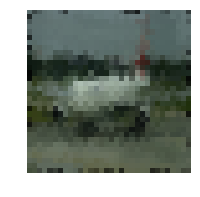

In [1393]:
show_image(do_affine(x(), funcs=partial(jitter, magnitude=0.05)))

# Transform pipeline

## Fin